In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

random_seed = 42

In [3]:
date_parser = lambda x : datetime.strptime(x, "%d/%m/%Y %H:%M:%S")
df = pd.read_csv("./data/Modelar_UH2021.txt", sep="|", parse_dates=['fecha'],
                 date_parser=date_parser)

Se puede ver que se leen las fechas para algunas filas mal quitando el parser y comparando los valores únicos de las fechas del principio y del final, donde se ve que están cambiados de posición.

## 1. Análisis de Datos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4045022 entries, 0 to 4045021
Data columns (total 11 columns):
 #   Column             Dtype         
---  ------             -----         
 0   fecha              datetime64[ns]
 1   id                 int64         
 2   visitas            int64         
 3   categoria_uno      object        
 4   categoria_dos      float64       
 5   estado             object        
 6   precio             object        
 7   dia_atipico        int64         
 8   campaña            int64         
 9   antiguedad         float64       
 10  unidades_vendidas  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 339.5+ MB


In [5]:
df.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,"6,07",0,0,5241.0,3
2,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,2015-06-01,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0


<hr>

* Atributo `fecha`

In [32]:
print("Numero de días en el dataset (", df['fecha'][0], "-", df['fecha'][len(df)-1], ": ",len(df['fecha'].unique()))

Numero de días en el dataset ( 2015-06-01 00:00:00 - 2016-09-30 00:00:00 :  487


¿Qué día de la semana agrupa más compras? ¿Qué mes del año?

In [64]:
df["weekday"] = df["fecha"].map(lambda x: x.weekday()) # Lunes = 0; Domingo = 6

ventas_per_weekday = df.groupby(["weekday"])["unidades_vendidas"].sum() / df["weekday"].value_counts()

0    5.085910
1    3.221597
2    2.488583
3    4.656646
4    5.759343
5    6.173217
6    5.507114
dtype: float64


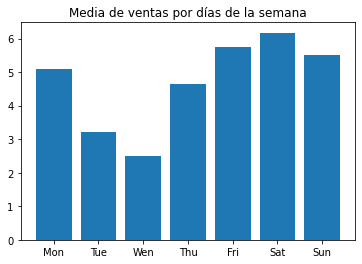

In [58]:
print(ventas_per_weekday)
plt.bar(range(0,7), ventas_per_weekday.values)
plt.title("Media de ventas por producto por días de la semana")
plt.xticks(range(0,7), ["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"])
plt.show()

Los resultados indican que los días en los que más se venden productos son los viernes, sábados y domingos.

In [59]:
df["month"] = df["fecha"].map(lambda x: x.month)
ventas_per_month = df.groupby(["month"])["unidades_vendidas"].sum() / df["month"].value_counts()

1      5.237830
2      4.341917
3      3.970224
4      3.764881
5      3.977774
6      3.484608
7      4.863620
8      3.456875
9      4.241843
10     4.014661
11    10.989706
12     6.736071
dtype: float64


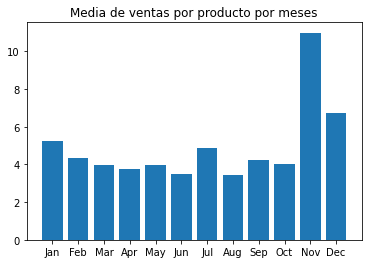

In [62]:
print(ventas_per_month)
plt.bar(range(0,12), ventas_per_month.values)
plt.title("Media de ventas por producto por meses")
plt.xticks(range(0,12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

Se obtiene que los meses Noviembre, Diciembre y Enero son los más exitosos en cuanto a ventas

¿Cómo queda la relación entre meses y días de la semana? Se crea un 'heatmap' para visualizarlo:

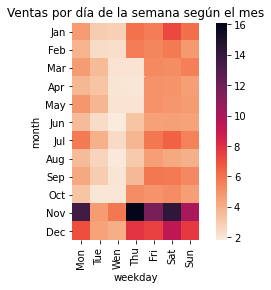

In [96]:
import seaborn as sns

piv = pd.pivot_table(df, values="unidades_vendidas",index=["month"], columns=["weekday"], fill_value=0)

ax = sns.heatmap(piv, cmap = sns.cm.rocket_r, square=True, 
                 xticklabels=["Mon", "Tue", "Wen", "Thu", "Fri", "Sat", "Sun"],
                 yticklabels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Ventas por día de la semana según el mes")
plt.show()

Parecen ser atributos que pueden ayudar a la hora de predecir el número de unidades vendidas. Se mantendrán en el dataframe.

¿Afecta al número de ventas que sea principio o final de mes? Partiendo de la suposición de que el pago de la nómina se realiza en los cinco primeros días del mes siguiente del devengo. 

In [123]:
dias_mes = {}
for y in [2015, 2016]:
    dias_mes[y]=[]
    for m in range(1,13):
        # Cálculo de ultimo dia del mes
        next_m = m+1 if m < 12 else 1
        next_y = y if m < 12 else y+1
        last_day = date(next_y, next_m, 1) - date(y, m, 1)
        # Lista con cinco últimos días para mes y año concreto
        dias_mes[y].append([last_day.days,last_day.days-1,last_day.days-2,last_day.days-3,last_day.days-4])

> Fin de mes:

In [132]:
df["fin_de_mes"] = df["fecha"].map(lambda x: x.day in dias_mes[x.year][x.month-1])
ventas_fin_mes = df.groupby(["fin_de_mes"])["unidades_vendidas"].sum() / df["fin_de_mes"].value_counts()

fin_de_mes
False    4.726018
True     4.525150
dtype: float64


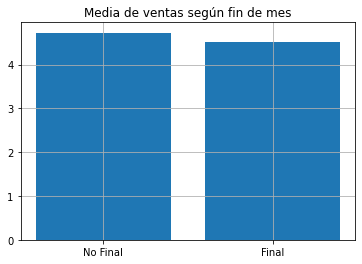

In [139]:
print(ventas_fin_mes)
plt.bar(range(0,2), ventas_fin_mes.values)
plt.title("Media de ventas según fin de mes")
plt.xticks(range(0,2), ["No Final", "Final"])
plt.grid()
plt.show()

> Inicio de mes:

In [135]:
df["principio_de_mes"] = df["fecha"].map(lambda x: x.day in range(1,6))
ventas_ini_mes = df.groupby(["principio_de_mes"])["unidades_vendidas"].sum() / df["principio_de_mes"].value_counts()

principio_de_mes
False    4.645257
True     4.938537
dtype: float64


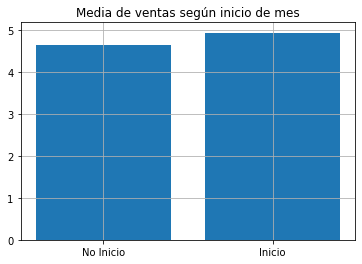

In [138]:
print(ventas_ini_mes)
plt.bar(range(0,2), ventas_ini_mes.values)
plt.title("Media de ventas según inicio de mes")
plt.xticks(range(0,2), ["No Inicio", "Inicio"])
plt.grid()
plt.show()

No parece que estos atributos puedan dar pistas sobre el número de unidades vendiadas para cada día. Se descartan:

In [140]:
df.drop(["principio_de_mes", "fin_de_mes"], axis=1, inplace=True)

<hr>

* Atributos `categoria_uno` y `estado`

In [9]:
df["categoria_uno"].value_counts()

A    1571062
K     581478
H     489922
F     458267
E     322394
G     174346
C     173372
L     115419
B      78407
I      67206
O       7305
N       5357
D        487
Name: categoria_uno, dtype: int64

In [10]:
df["estado"].value_counts()

No Rotura    3388184
Rotura        606530
Transito       50308
Name: estado, dtype: int64

In [11]:
df['estado'] = df['estado'].astype('category')
df['categoria_uno'] = df['categoria_uno'].astype('category')

En lugar de que sean objetos, que sean categorías que es un tipo más eficiente para estos tipos de datos

In [12]:
df['categoria_uno'].dtype

CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N',
                  'O'],
                 ordered=False)

In [13]:
df["estado"].dtype

CategoricalDtype(categories=['No Rotura', 'Rotura', 'Transito'], ordered=False)

<hr>

* Atributo `categoria_dos`

In [14]:
print("Número de categorías en 'categoria_dos':", df['categoria_dos'].nunique())

Número de categorías en 'categoria_dos': 182


<AxesSubplot:>

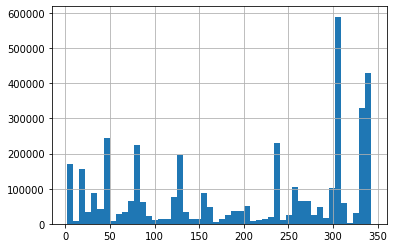

In [17]:
df['categoria_dos'].hist(bins=50)

<hr>

* Atributo `precio`

El precio se detecta como tipo `object` porque usa la coma en vez del punto. Se modifica para poder hacer operaciones con él.

In [18]:
df["precio"] = df["precio"].str.replace(",", ".").astype(float)

In [19]:
df["precio"].dtype

dtype('float64')

In [20]:
df["precio"].max(), df["precio"].min(), df["precio"].mean(), df["precio"].std()

(175.78, 3.57, 34.24319426208051, 23.309432664059635)

<hr>

* Atributo `dia_atipico`

In [21]:
df["dia_atipico"].value_counts()

 0    3505132
 1     398688
-1     141202
Name: dia_atipico, dtype: int64

<hr>

* Atributo `campaña`

In [22]:
df["campaña"].value_counts()

0    4033689
1      11333
Name: campaña, dtype: int64

<hr>

* Atributo `antiguedad`

In [143]:
df["antiguedad"].isnull() / len(df),  df["antiguedad"].notnull() / len(df)

(0          0.000000e+00
 1          0.000000e+00
 2          2.472174e-07
 3          2.472174e-07
 4          0.000000e+00
                ...     
 4045017    0.000000e+00
 4045018    0.000000e+00
 4045019    0.000000e+00
 4045020    0.000000e+00
 4045021    0.000000e+00
 Name: antiguedad, Length: 4045022, dtype: float64,
 0          2.472174e-07
 1          2.472174e-07
 2          0.000000e+00
 3          0.000000e+00
 4          2.472174e-07
                ...     
 4045017    2.472174e-07
 4045018    2.472174e-07
 4045019    2.472174e-07
 4045020    2.472174e-07
 4045021    2.472174e-07
 Name: antiguedad, Length: 4045022, dtype: float64)

<hr>

In [23]:
df.describe(include=['int64', 'float64', 'object'])

,id,visitas,categoria_dos,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
count,4.045022e+06,4.045022e+06,4.039178e+06,1.402111e+06,4.045022e+06,4.045022e+06,3.170857e+06,4.045022e+06
mean,2.745180e+05,1.721371e+02,2.016524e+02,3.424319e+01,6.365503e-02,2.801715e-03,1.011114e+03,4.693434e+00
std,8.336719e+04,6.889116e+02,1.179997e+02,2.330943e+01,3.597475e-01,5.285704e-02,7.162509e+02,2.237403e+01
min,2.197200e+04,0.000000e+00,2.000000e+00,3.570000e+00,-1.000000e+00,0.000000e+00,1.260000e+02,0.000000e+00
25%,2.122940e+05,7.000000e+00,8.200000e+01,1.652000e+01,0.000000e+00,0.000000e+00,5.240000e+02,0.000000e+00
50%,2.926720e+05,3.500000e+01,2.360000e+02,2.689000e+01,0.000000e+00,0.000000e+00,7.950000e+02,0.000000e+00
75%,3.379000e+05,1.300000e+02,3.070000e+02,4.535000e+01,0.000000e+00,0.000000e+00,1.244000e+03,3.000000e+00
max,4.586600e+05,1.200450e+05,3.430000e+02,1.757800e+02,1.000000e+00,1.000000e+00,5.310000e+03,4.881000e+03


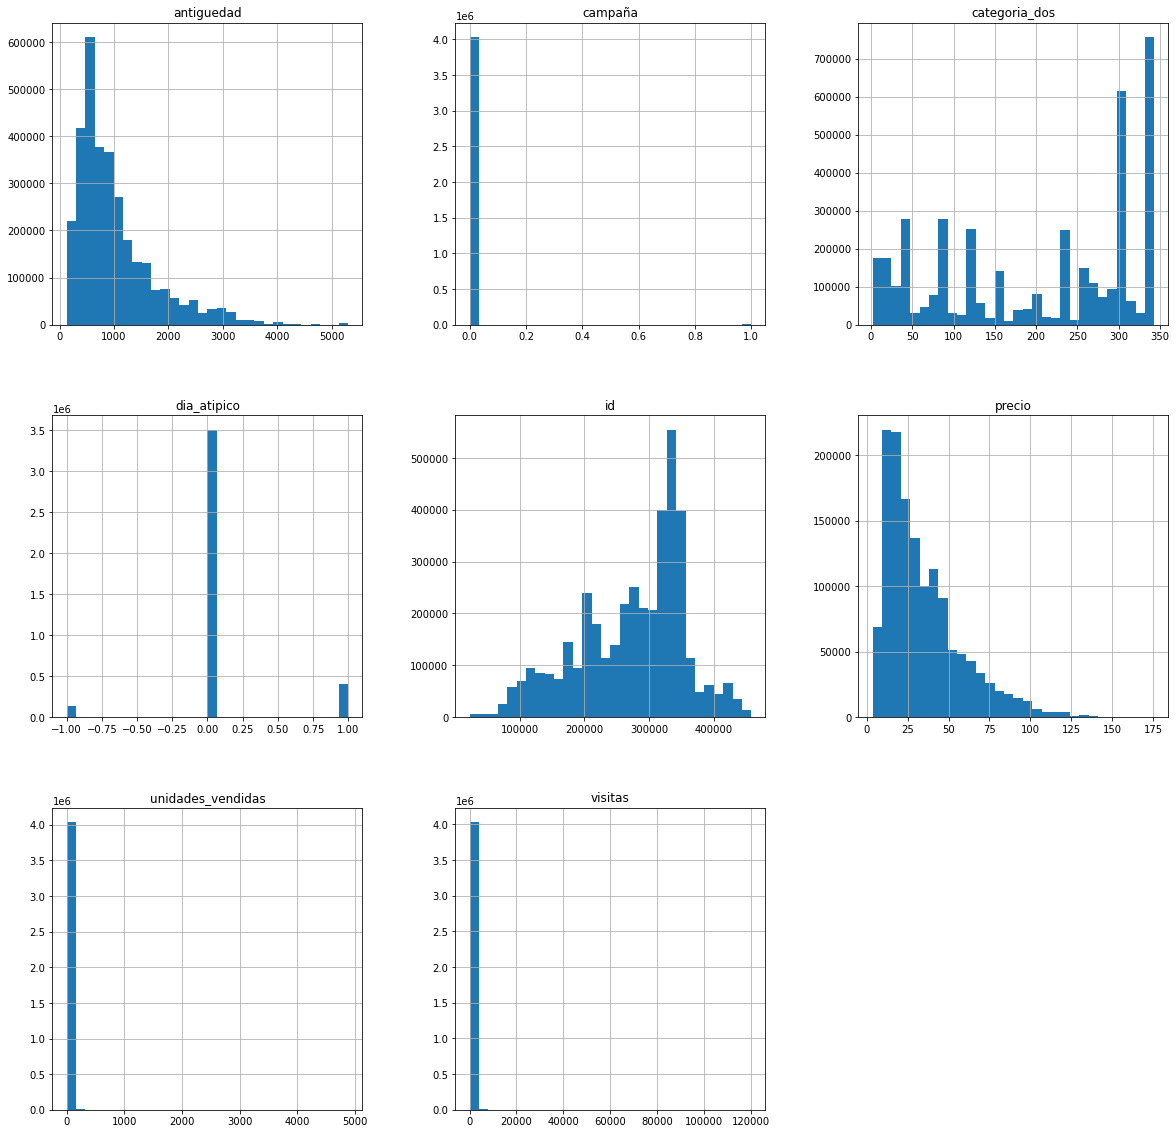

In [20]:
df.hist(bins=30, figsize=(20,20))
plt.show()

## 2. Preprocesamiento de Datos

### Duplicados

**¿Puede haber varias entradas de un mismo id en un mismo día?**

In [21]:
df2 = df.groupby(['fecha', 'id'])

In [22]:
df2.size()

fecha       id    
2015-06-01  21972     1
            23910     1
            24306     2
            27144     1
            27504     1
                     ..
2016-09-30  456982    1
            457416    1
            457422    1
            458650    1
            458660    2
Length: 2029816, dtype: int64

Por ejemplo `id` = 24306 para `fecha` = 2015-06-01

In [23]:
df.loc[(df.fecha=="2015-06-01") & (df.id==24306)]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
2,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
3,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0


In [24]:
sum(list(df2.size() > 1))

677904

In [25]:
len(df[df.duplicated()])

2004985

Hay filas repetidas en el dataset. En concreto **677904 casos**, haciendo un total de **2004985 filas**.

Se procede a eliminar los casos duplicados.

In [26]:
df_duplicates_removed = df.drop_duplicates(keep="first")
print("Número de filas tras eliminar duplicados: ", len(df_duplicates_removed))

Número de filas tras eliminar duplicados:  2040037


### Missing values

Comprobamos qué categorías tienen valores `null`.

In [27]:
df_duplicates_removed.isnull().any()

fecha                False
id                   False
visitas              False
categoria_uno        False
categoria_dos         True
estado               False
precio                True
dia_atipico          False
campaña              False
antiguedad            True
unidades_vendidas    False
dtype: bool

In [28]:
print("Porcentaje (%) de valores null: ")
100 * df_duplicates_removed.isnull().sum() / len(df_duplicates_removed)

Porcentaje (%) de valores null: 


fecha                 0.000000
id                    0.000000
visitas               0.000000
categoria_uno         0.000000
categoria_dos         0.215339
estado                0.000000
precio               68.620618
dia_atipico           0.000000
campaña               0.000000
antiguedad           23.568935
unidades_vendidas     0.000000
dtype: float64

Los atributos `categoria_dos`, `precio` y `antiguedad` tienen *missing values*. En la información del dataset nos dicen que para `precio` hay que completarlo con el valor de la fecha anterior más cercana. De los demás no dice nada. 

In [29]:
df_updated_prices = df_duplicates_removed.copy()

In [30]:
df_updated_prices['precio'] = df_duplicates_removed.groupby(['id'])['precio'].ffill()

In [31]:
df_updated_prices.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,6.07,0,0,5241.0,3
2,2015-06-01,24306,13,A,46.0,No Rotura,NaN,0,0,NaN,0
4,2015-06-01,27144,15,E,230.0,No Rotura,NaN,0,0,4064.0,0
5,2015-06-01,27504,7,C,157.0,No Rotura,NaN,0,0,5261.0,0


In [32]:
df_updated_prices['precio'].isnull().sum()

260447

In [33]:
len(df_updated_prices[(df_updated_prices['id'] == 21972) & (df_updated_prices['precio'].isnull())])

5

In [34]:
df_updated_prices[(df_updated_prices['id'] == 21972)][:7]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
8306,2015-06-02,21972,0,C,75.0,No Rotura,NaN,0,0,5241.0,0
16612,2015-06-03,21972,1,C,75.0,No Rotura,NaN,0,0,5241.0,0
24918,2015-06-04,21972,1,C,75.0,No Rotura,NaN,0,0,5241.0,0
33224,2015-06-05,21972,3,C,75.0,No Rotura,NaN,0,0,5241.0,0
41530,2015-06-06,21972,1,C,75.0,No Rotura,5.84,0,0,5241.0,3
49836,2015-06-07,21972,1,C,75.0,No Rotura,5.84,0,0,5241.0,0


In [35]:
len(df_updated_prices[(df_updated_prices['id'] == 21972) & (df_updated_prices['precio'].notnull())])

482

In [36]:
len(df_updated_prices[(df_updated_prices['id'] == 21972)])

487

Hay algunos valores con el precio nulo que no tienen valor anterior no-nulo más próximo como se muestra arriba.

Para estos valores se rellenará con el precio más antiguo del que se tenga constancia.

In [37]:
df_fill_prices = df_updated_prices.copy()
df_fill_prices['precio'] = df_updated_prices.sort_values(by="fecha", ascending=False) \
                                .groupby(['id'])['precio'].ffill()

La columna `antiguedad` puede descartarse ya que:
* No hay forma de calcular los valores para los ejemplo que son null. 
* Para los ejemplos no null, el valor de `antiguedad` es fijo para el mismo producto independientemente de la fecha.

In [38]:
df_drop_antiguedad = df_fill_prices.drop(["antiguedad"], axis=1)

In [39]:
df_drop_antiguedad.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,unidades_vendidas
0,2015-06-01,21972,0,C,75.0,No Rotura,5.84,0,0,0
1,2015-06-01,23910,5,C,170.0,No Rotura,6.07,0,0,3
2,2015-06-01,24306,13,A,46.0,No Rotura,7.85,0,0,0
4,2015-06-01,27144,15,E,230.0,No Rotura,6.12,0,0,0
5,2015-06-01,27504,7,C,157.0,No Rotura,10.74,0,0,0


Para la columna `categoria_dos` hay pocos casos en los que el valor es null. Se comprobará si existe la opción de completar el campo con las filas con el mismo `id` que tengan un valor.

In [40]:
def check_categoria_dos(row):
    aux_array = df_drop_antiguedad[(df_drop_antiguedad.id == row.id) & \
                              (df_drop_antiguedad["categoria_dos"]).notnull()].categoria_dos
    if len(aux_array) > 0:
        print(new_value, row.categoria_dos)
        

In [41]:
index_no_cat2 = df_drop_antiguedad["categoria_dos"].isnull()

df_drop_antiguedad[index_no_cat2].apply(check_categoria_dos, axis=1);

No existen productos que tengan un valor en `categoria_dos` para una fecha y ninguna para otra. Para todos los casos en los que `categoria_dos` es null, lo es para todas las filas con el mismo `id`.

Se utilizará `IterativeImputer` para poder rellenar `categoria_dos` utilizando el resto de los atributos. Se hará tras la codificación de los atributos categóricos en el siguiente apartado.

Los atributos categóricos `categoria_uno`, `estado`, `dia_atipico` y `campaña` serán transformados a atributos numéricos para poder utilizar `IterativeImputer`.

In [42]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
cat1_encoded = encoder.fit_transform(df_drop_antiguedad['categoria_uno'].to_numpy().reshape(-1,1)).ravel()
estado_encoded = encoder.fit_transform(df_drop_antiguedad['estado'].to_numpy().reshape(-1,1)).ravel()

/home/jorge/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [43]:
df_encoded = df_drop_antiguedad.copy()

df_encoded['categoria_uno'] = cat1_encoded
df_encoded['estado'] = estado_encoded

Ahora es posible rellenar el valor de `categoria_dos` utilizando `IterativeImputer`.

In [44]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [45]:
imputer = IterativeImputer(random_state=0)

index_cat2 = df_encoded["categoria_dos"].notnull()

# Solo nos interesa rellenar "categoria_dos", "precio" no. "fecha" es utilizado por IterativeImputer
imputer.fit(df_encoded[index_cat2].drop(["fecha", "precio"], axis=1).values) 

IterativeImputer(random_state=0)

In [46]:
cat2_filled = imputer.transform(df_encoded[index_no_cat2].drop(["fecha", "precio"], axis=1).values)

In [47]:
df_clean = df_encoded.copy()

index_aux = list(df_encoded.drop(["fecha", "precio"], axis=1).columns).index("categoria_dos")
df_clean.loc[index_no_cat2,["categoria_dos"]] = cat2_filled[:, index_aux]

### Relaciones entre atributos

Cuando hay campaña no hay casi roturas en comparación con cuando no hay campaña, ya que se debe estar más preparado por si esto pueda ocurrir:

In [48]:
df_updated_prices.groupby(['estado', 'campaña']).size()

estado     campaña
No Rotura  0          1691255
           1             8819
Rotura     0           313138
           1               92
Transito   0            26498
           1              235
dtype: int64

Cuando hay campaña no hay días con menos demanda de la habitual, y no es un factor muy determinante para que haya más demanda de la habitual:

In [49]:
df_updated_prices.groupby(['dia_atipico', 'campaña']).size()

dia_atipico  campaña
-1           0            70907
 0           0          1760154
             1              317
 1           0           199830
             1             8829
dtype: int64

A simple vista no hay una clara relación entre que haya stock del artículo y sea un día atípico:

In [50]:
df_updated_prices.groupby(['estado', 'dia_atipico']).size()

estado     dia_atipico
No Rotura  -1               60780
            0             1461621
            1              177673
Rotura     -1                9431
            0              277074
            1               26725
Transito   -1                 696
            0               21776
            1                4261
dtype: int64

In [51]:
categorias_grouped = df_updated_prices.groupby(['categoria_uno'])

In [52]:
categorias_grouped.agg(
    {"visitas" : ["sum", "mean"],
     "precio" : ["mean", "var"],
     "unidades_vendidas" : ["sum", "mean"]
     }).sort_values(by=('visitas', 'sum'), ascending=False)

visitas                 precio              unidades_vendidas  \
                    sum        mean       mean          var               sum   
categoria_uno                                                                   
A              81131445  119.339379  28.263037   243.366228           2997753   
F              58164202  207.376013  63.173215  1103.729258            698949   
K              44662005  139.166921  36.330386   709.895463           1203780   
H              37514821  187.856830  52.954243   939.734164            727728   
E              13493911   83.806865  26.180268   262.021818            455445   
G               5756218   68.111250  22.775422    87.308980            296127   
L               4686432   87.963511  32.803443   323.197828            156666   
C               3417910   20.882935   9.747325    17.533307            780309   
I               2510580   68.467874  30.970910   280.224712             72783   
O               1661594  485.278621  51.841973   243.718873             17151   
B                547093   10.589853  16.017399    29.465366            121737   
N                295894   67.447914  18.235093    13.793831              7797   
D                  9695   19.907598  14.941250     0.552172              1008   

                         
                   mean  
categoria_uno            
A              4.409511  
F              2.492001  
K              3.750982  
H              3.644124  
E              2.828640  
G              3.503964  
L              2.940594  
C              4.767575  
I              1.984919  
O              5.009054  
B              2.356413  
N              1.777297  
D              2.069815

In [53]:
categorias_grouped.agg({"categoria_dos" : ["mean", "min", "max"],})

categoria_dos              
                       mean    min    max
categoria_uno                            
A                152.834884   16.0  343.0
B                269.719697   57.0  312.0
C                119.101668   63.0  170.0
D                264.000000  264.0  264.0
E                168.957827   10.0  323.0
F                266.847121   20.0  341.0
G                158.099761   29.0  298.0
H                251.840557    2.0  326.0
I                169.016581    5.0  331.0
K                196.194224    7.0  340.0
L                226.985923   14.0  296.0
N                188.748119  116.0  278.0
O                226.000000  226.0  226.0

Cuando hay campaña se venden muchos más artículos:

In [54]:
df_updated_prices.groupby(["categoria_uno", "campaña"]).agg({"unidades_vendidas" : ["mean", "var"]})

unidades_vendidas              
                                   mean           var
categoria_uno campaña                                
A             0                4.101826    327.119103
              1               56.304467  18828.547317
B             0                2.336963     32.795300
              1               24.666667   1575.772727
C             0                4.763017    402.513657
              1               24.394737    580.461593
D             0                2.069815     42.484828
              1                     NaN           NaN
E             0                2.615365    314.998913
              1               44.698529  11976.335998
F             0                2.253366    124.493919
              1               67.172648  38814.478902
G             0                3.447359     69.709483
              1               21.099631    781.290037
H             0                3.373717    186.068481
              1               38.234990   8019.978336
I             0                1.892467     41.311756
              1               24.644295   1803.352349
K             0                3.494347    369.295150
              1               84.958457  59308.768569
L             0                2.804356    122.774329
              1               38.038835   5118.535070
N             0                1.754510     20.173389
              1               14.250000    369.642857
O             0                4.875330    155.225943
              1               35.400000   1917.257143

In [55]:
correlation_matrix = df_updated_prices.corr()

In [56]:
correlation_matrix['unidades_vendidas'].sort_values(ascending=False)

unidades_vendidas    1.000000
visitas              0.406862
campaña              0.174756
dia_atipico          0.081030
antiguedad           0.033407
categoria_dos        0.009226
precio              -0.027439
id                  -0.030349
Name: unidades_vendidas, dtype: float64

### One-Hot Vector

Se transforman todos los atributos categóricos del dataframe a vectores one hot. Se incluyen `categoria_uno`, `estado`, `dia_atipico` y `campaña`. El haberlos transformado a numéricos con `LabelEncoder` no debería afectar al resultado de OneHot.

In [57]:
df_prep = df_clean.copy()

### Scaler

Se estandarizan los atributos numéricos (excepto `id`).

In [58]:
from sklearn.preprocessing import StandardScaler

In [59]:
cat_att = ['categoria_uno', 'estado', 'dia_atipico', 'campaña']

scaler = StandardScaler()

df_scaled = df_prep.copy()
df_scaled.loc[:, ["visitas",
                  "categoria_dos",
                  "precio"]] = scaler.fit_transform(df_prep.drop(cat_att + ["fecha","unidades_vendidas","id"],axis=1))

In [60]:
df_scaled

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,unidades_vendidas
0,2015-06-01,21972,-0.209219,2,-0.934538,0,-1.103112,0,0,0
1,2015-06-01,23910,-0.200812,2,-0.157059,0,-1.094568,0,0,3
2,2015-06-01,24306,-0.187361,0,-1.171873,0,-1.028447,0,0,0
4,2015-06-01,27144,-0.183999,4,0.333981,0,-1.092711,0,0,0
5,2015-06-01,27504,-0.197450,2,-0.263450,0,-0.921092,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4045016,2016-09-30,456982,10.845677,5,1.201484,0,1.699249,0,0,30
4045017,2016-09-30,457416,2.136269,5,1.201484,0,0.551410,0,0,9
4045018,2016-09-30,457422,1.606642,5,1.201484,1,2.163214,0,0,0
4045019,2016-09-30,458650,2.119455,9,1.234220,0,1.311807,0,0,0


## 3. Creación de Modelo(s)

### División de conjuntos. 

* Entrenamiento: 70%
* Testeo: 20%
* Validación: 10%

Se debe descartar como atributos `unidades_vendidas`, al ser lo que se pretende predecir, y `fecha` al no ser un atributo numérico ni categórico.

In [61]:
from sklearn.model_selection import train_test_split

X = df_scaled.drop(["unidades_vendidas", "fecha"], axis=1).values
y = df_scaled["unidades_vendidas"].values

In [62]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=.2,random_state =random_seed)

In [63]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/8, random_state =random_seed)

### Función de pérdida:

Podrá ser utilizada como función de pérdida a mejorar en modelos de redes neuronales y servirá para calcular qué error tiene cada modelo.

In [64]:
from sklearn.metrics import mean_squared_error

def contest_loss (y_real, y_pred):
    cf = sum([i < j for i, j in zip(y_real, y_pred)])/len(y_real) # Cuando la demanda no haya superado a la predicción
    rmse = mean_squared_error(y_real, y_pred, squared=False) # Root Mean Squared Error
    rrmse = rmse / np.mean(y_pred) # rRMSE
    return 0.7 * rrmse + 0.3 * (1 - cf)

### LazyPredictor - Regresión

In [65]:
'''from lazypredict.Supervised import LazyRegressor

# FIXME: do not run
lazy = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=contest_loss)
models, predictions = lazy.fit(X_train, X_val, y_train, y_val)
print(models)'''

'from lazypredict.Supervised import LazyRegressor\n\n# FIXME: do not run\nlazy = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=contest_loss)\nmodels, predictions = lazy.fit(X_train, X_val, y_train, y_val)\nprint(models)'

### Importancia relativa de los atributos calculada viendo cuantos nodos de los árboles usan ese atributo para reducir la impureza

In [66]:
from sklearn.ensemble import RandomForestRegressor


random_forest_regressor = RandomForestRegressor(n_estimators=30)
random_forest_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [67]:
for name, score in zip(df_scaled.drop(["unidades_vendidas", "fecha"], axis=1).columns, random_forest_regressor.feature_importances_):
    print(name, score)

id 0.1437522065340492
visitas 0.4071824913173186
categoria_uno 0.024176692642000064
categoria_dos 0.06883025863955056
estado 0.011332286569441494
precio 0.2614017324565653
dia_atipico 0.07965361169064474
campaña 0.003670720150430121
